# Antiferromagnetic State Preparation: Using a Parametrized Sequence

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import CustomWaveform, RampWaveform

from scipy.optimize import minimize

## 1. Introduction

**Parametrized** Sequences are useful when we want to construct several `Sequence` instances while changing some of their defining parameters (for example the amplitude, the detuning or the duration of the pulses). 

This tutorial is based on the "Antiferromagnetic State Preparation" tutorial. The construction process is not too different from the usual `Sequence` design, but it applies the parametrization of the sequences with a set of time variables, and then proceeds to build the actual sequences with each desired value.

## 2. Register

Interatomic Radius is: 8.755755639490728µm.


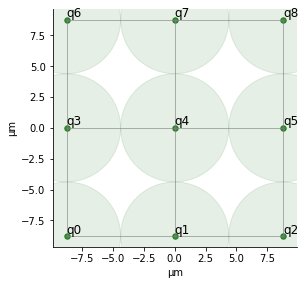

In [2]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2*np.pi
delta_0 = -12 * 2*np.pi 
delta_f = 2 * 2*np.pi

t_rise = 252 
t_fall = 500 
t_sweep = 1000 * (delta_f - delta_0) / (2*np.pi*10) 

# Find a proper interatomic distance:
U = Omega_max / 1.3 # in rad/µs
R_interatomic = Chadoq2.rydberg_blockade_radius(U) # This function takes rad/µs

N_side = 3
reg = Register.square(N_side, R_interatomic, prefix='q')
print(f'Interatomic Radius is: {R_interatomic}µm.')
reg.draw(blockade_radius=R_interatomic, draw_graph=True, draw_half_radius=True )

## 2. Build parametrized sequences

Notice next how we construct the sequences with parametrized variables. This is done using the. `.declare_variable()` method. We store these parameters in two lists. Next, we construct the sequence as usual, where the methods are stored until the actual building takes place.

In [3]:
# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0','rydberg_global')

delta_0 = seq.declare_variable('delta_0', size=1)
delta_f = seq.declare_variable('delta_f', size=1)

rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

seq.add(rise, 'ch0')
seq.add(sweep, 'ch0')
seq.add(fall, 'ch0')

Once we have the parameters that we want to apply, we use the `.build()` method to assign these values into a `assigned_sequence` sequence. It is this sequence which is simulated every time the `quantum_evolution()` function is called:

In [4]:
def quantum_evolution(parameters, draw=False):
    d_0, d_f = parameters
    assigned_sequence = seq.build(delta_0=d_0, delta_f=d_f)
    assigned_sequence.measure('ground-rydberg')
    
    simul = Simulation(assigned_sequence, sampling_rate=.1)
    if draw:
        simul.draw()
    results = simul.run()
    return results.sample_final_state(5000)

We can then plot the distribution of the samples, to see the most frequent bitstrings sampled.

In [5]:
afm_states = ["".join([str(i%2) for i in range(N_side**2)]), 
              "".join([str((i+1)%2) for i in range(N_side**2)])]
print(afm_states)


['010101010', '101010101']


In [6]:
def plot_distribution(results):
    C = dict(Counter(results).most_common())
    color_dict = {key:'red' if key in afm_states else 'gray' for key in C}
    
    plt.figure(figsize=(8,2))
    plt.xlabel("bitstrings")
    plt.ylabel("counts (%)")
    plt.bar(C.keys(), 100*np.array([*C.values()])/sum([*C.values()]), width=0.5, color = color_dict.values())
    plt.xticks(afm_states, rotation='vertical')
    plt.xlim(-0.5,16+0.5)

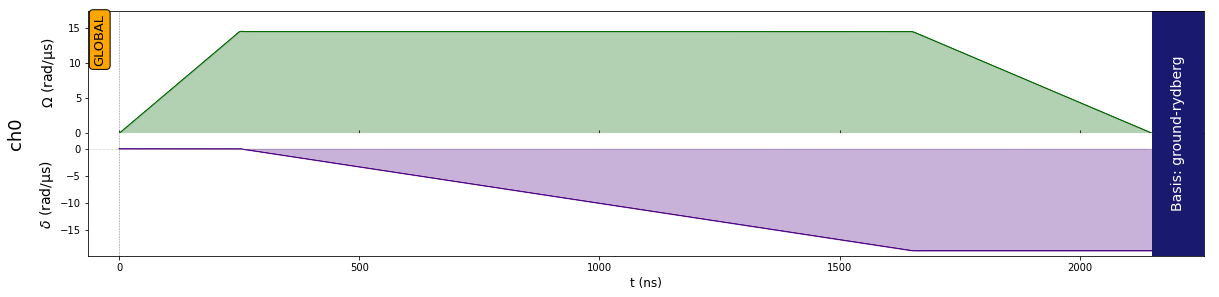

In [7]:
example_sampling = quantum_evolution([0 * 2*np.pi, -3* 2*np.pi], draw=True)

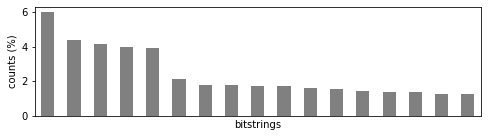

In [8]:
plot_distribution(example_sampling);

## 3. Optimization 

In [9]:
def diff(bitstring, A=0):
    # count different bits between the bitstring and the antiferromagnetic state:
    return sum(b != afm_states[A][i] for i,b in enumerate(bitstring))
    
def mean_diff(res, A=0):
    res_dict = dict(res)
    counts = sum(v * diff(k, A) for k, v in res_dict.items()) 
    result = counts / sum(res_dict.values()) # Divide by total samples
    return result

In [10]:
#make and array of values between -10 pi and 10 pi
N_params = 10
initial_array = np.linspace(-20 * 2*np.pi, 0, N_params)
final_array = np.linspace(0, 10 * 2*np.pi,  N_params)


In [11]:
all_costs = np.zeros((N_params, N_params))
for i,delta_0 in enumerate(initial_array):
    for j,delta_f in enumerate(final_array):
        C = quantum_evolution([delta_0, delta_f])
        all_costs[i,j] = mean_diff(C, 1)


Min cost: 1.0254
Corresponding delta_0: -17.77777777777778
Corresponding delta_f: 2.2222222222222223


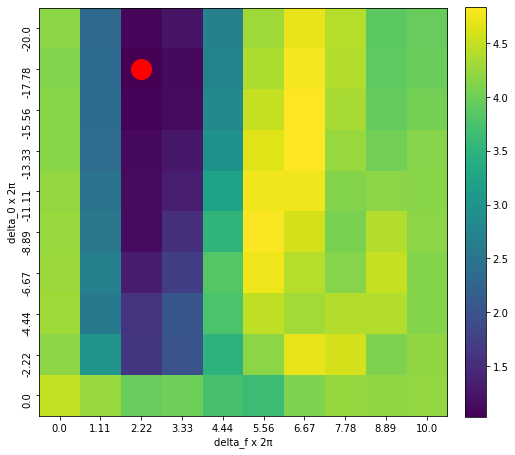

In [12]:
# make a heatmap with the arrays and the costs:
plt.figure(figsize=(8,8))
plt.imshow(all_costs)
plt.colorbar(fraction=0.046, pad=0.04) 
yvals = np.round(initial_array/(2*np.pi), 2)
xvals = np.round(final_array/(2*np.pi), 2)
plt.yticks(np.arange(N_params), yvals, rotation=90)
plt.xticks(np.arange(N_params), xvals)
plt.ylabel("delta_0 x 2π")
plt.xlabel("delta_f x 2π")

# show min diff in plot:
min_cost = np.min(all_costs)
min_cost_idx = np.where(all_costs == min_cost)
# print the min cost and the corresponding delta_0 and delta_f:
print(f'Min cost: {min_cost}')
print(f'Corresponding delta_0: {initial_array[min_cost_idx[0][0]]/2/np.pi}')
print(f'Corresponding delta_f: {final_array[min_cost_idx[1][0]]/2/np.pi}')
plt.scatter(min_cost_idx[1], min_cost_idx[0], color='red', s=400)

plt.show()

We can now plot the sample that we woud obtain using the best variational parameters:

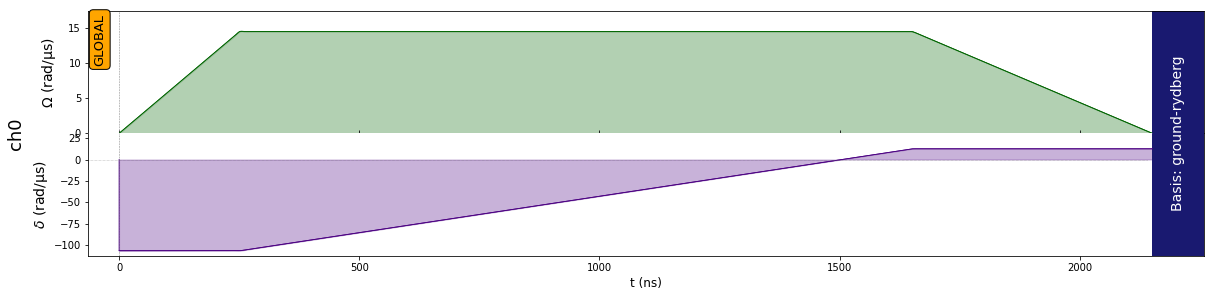

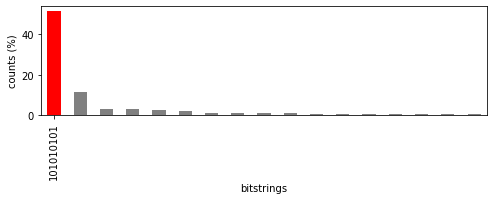

In [13]:
count_dict = example_sampling = quantum_evolution([-17 * 2*np.pi, 2* 2*np.pi], draw=True)
plot_distribution(count_dict)